In [11]:
#For analysis
import pandas as pd
import numpy as np

#Visulization purpose
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#For performing statstical model
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests


In [30]:
features = pd.read_csv('data folder/BTC-USD DAILY.csv')

In [31]:
features['Date'] = pd.to_datetime(features['Date'])
features.set_index('Date',inplace=True)

In [32]:
## features 

features_1 = [ 'Open', 'High', 'Low', 'Close', 'Adj Close']
features = features[features_1]
features.head()


,Open,High,Low,Close,Adj Close
Date,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

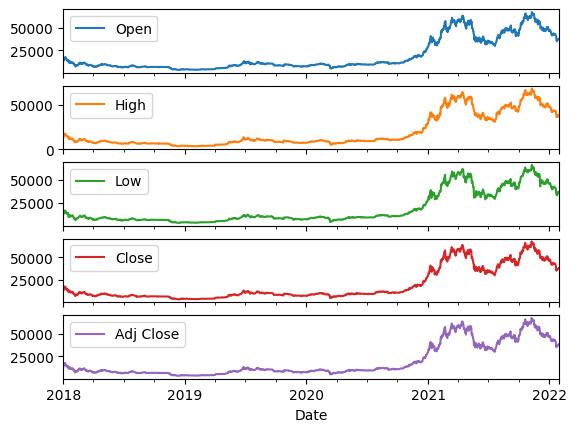

In [33]:
features.plot(subplots=True)

In [34]:
train_split = 1193

In [35]:

### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std

In [36]:
dataset

array([[0.21527033, 0.18053072, 0.1647784 , 0.17014817, 0.17014817],
       [0.17149584, 0.29619143, 0.16560801, 0.28841373, 0.28841373],
       [0.29307962, 0.30732002, 0.3223017 , 0.30795361, 0.30795361],
       ...,
       [2.3418643 , 2.30416624, 2.42553096, 2.35541344, 2.35541344],
       [2.37521655, 2.27726306, 2.42844299, 2.3357238 , 2.3357238 ],
       [2.35440421, 2.31032949, 2.3628033 , 2.38620457, 2.38620457]])

In [60]:
def multivariate_data(dataset, target, start_idx, end_idx, history_size, target_size, step, single_step=False):
    data = []
    labels = []
    start_idx = start_idx + history_size
    
    if end_idx is None:
        end_idx = len(dataset) - target_size
        
    for i in range(start_idx, end_idx):
        idxs = range(i - history_size, i, step)  # using step
        data.append(dataset[idxs])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])

    return np.array(data), np.array(labels)


In [81]:
### generate multivariate data

history = 44
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,future_target, STEP , single_step = True)

# x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split ,end_idx = None , history ,future_target, STEP, single_step = True)

# print(x_train_ss.shape , y_train_ss.shape)

In [82]:
x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split ,None , history ,future_target, STEP, single_step = True)
print(x_train_ss.shape , y_train_ss.shape)

(1149, 8, 5) (1,)


In [83]:
y_train_ss

array([2.27039857])

In [74]:
## tensorflow dataset

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)



NameError: name 'tf' is not defined

In [ ]:
### Modelling using LSTM

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)

In [ ]:
## plot train test loss 

def plot_loss(history , title):
loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

In [ ]:

# plot time series and predicted values

for x, y in val_ss.take(5):
    plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

In [ ]:

future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

In [ ]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()
     

In [ ]:

#plotting function
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.grid()
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
      plt.show()
  


In [ ]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
     

In [ ]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')


In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])